In [1]:
from BioLink.biolink_client import BioLinkWrapper
import pandas as pd
from pprint import pprint
from collections import defaultdict
from mygene import MyGeneInfo
import cache_magic

In [2]:
# instantiate helpers
blw = BioLinkWrapper()
mg = MyGeneInfo()

In [3]:
def map_id(in_id):
    return blw.get_obj(obj_id=in_id)['id']

# Workflow 2 
## Bardet-biedl implementation

## Module declaration

In [4]:
worklow_modules = [
    ('Mod1A', 'Mod1A Functional Similarity'),
    ('Mod1B', 'Mod1B Phenotype Similarity'),
    ('Mod1C', 'Mod1C Coexpression'),
    ('Mod1D', 'Mod1D Gene Chemical Interaction'),
    ('Mod1E', 'Mod1E Gene Interaction'),
    ('Mod3', 'Mod3 Candidate Merging')
]

## Workflow input

# Mod0 Input Lookup
## Get Disease associated genes from BioLink API api.monarchinitative.org

In [5]:
from Modules.Mod0_lookups import LookUp

# workflow input is a disease identifier
lu = LookUp()

Mod O DiseaseGeneLookup metadata:
{'data_type': 'disease',
 'input_type': {'complexity': 'single', 'id_type': ['MONDO', 'DO', 'OMIM']},
 'limit': None,
 'output_type': {'complexity': 'set', 'id_type': 'HGNC'},
 'predicate': 'blm:gene associated with condition',
 'source': 'Monarch Biolink',
 'taxon': 'human'}


In [6]:
input_disease = 'MONDO:0015229' # Bardet-biedl
input_object = {
    'input': input_disease,
    'parameters': {
        'taxon': 'human',
        'threshold': None,
    },
}
lu.load_input_object(input_object=input_object)
%cache input_object = lu.input_object

{'description': 'Bardet-Biedl syndrome (BBS) is a ciliopathy with multisystem '
                'involvement.',
 'id': 'MONDO:0015229',
 'label': 'Bardet-Biedl syndrome'}
Loading cached value for variable 'input_object'. Time since caching: 2 days, 0:52:30.655065


In [7]:
# get genes associated with disease from Biolink
%cache disease_associated_genes = lu.disease_geneset_lookup()
# create list of gene curies for downstream module input
%cache input_curie_set = disease_associated_genes['hit_id'].tolist()
# # show the 
%cache disease_associated_genes

Loading cached value for variable 'disease_associated_genes'. Time since caching: 2 days, 0:52:00.856730
Loading cached value for variable 'input_curie_set'. Time since caching: 2 days, 0:52:00.855414
Loading cached value for variable 'disease_associated_genes'. Time since caching: 2 days, 0:52:00.859676


In [34]:
from GraphVisuals.graphviz_wrapper import PathGraph

# instantiate workflow graph
path_graph = PathGraph(input_curie=input_object['id'], input_label=input_object['label'])
path_graph.load_nodes(node_list=worklow_modules)

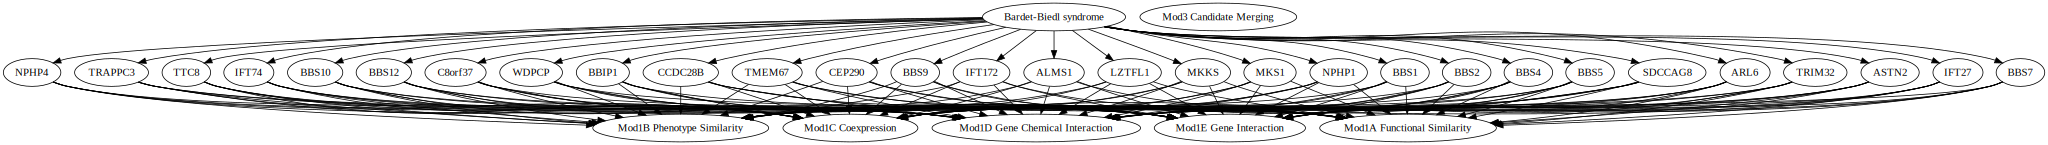

In [35]:
# graph fanconi genes 2 mod1
path_graph.load_nodes(list(zip(disease_associated_genes['hit_id'], disease_associated_genes['hit_label'])))
path_graph.module_outputs(output_gene_set=input_curie_set, module_id=path_graph.conv_pref(input_disease))
for module in worklow_modules[:-1]:
    path_graph.module_inputs(input_gene_set=input_curie_set, module_id=module[0])
path_graph.path_graph

In [10]:
# start a list of final candidates from each module
mod1_candidates = list()

# Mod1A Functional Similarity
## Find similar genes based on GO functional annotations using OntoBio Jaccard similarity

In [11]:
from Modules.Mod1A_functional_sim import FunctionalSimilarity

# Module specification
mod1a_input_object = {
    'input': input_curie_set,
    'parameters': {
        'taxon': 'human',
        'threshold': 0.75,
    },
}
    
func_sim = FunctionalSimilarity()

/Users/tputman/.virtualenvs/modules/lib/python3.6/site-packages/cachier/mongo_core.py:24: UserWarning: Cachier warning: pymongo was not found. MongoDB cores will not work.
  "Cachier warning: pymongo was not found. MongoDB cores will not work.")


Mod1A Functional Similarity metadata:
{'input_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'output_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'predicate': ['blm:macromolecular machine to biological process association',
               'macromolecular machine to molecular activity association'],
 'source': 'Monarch Biolink'}


In [12]:
mod1a_input_object = {
    'input': input_curie_set,
    'parameters': {
        'taxon': 'human',
        'threshold': 0.75,
    },
}
func_sim.load_input_object(mod1a_input_object)
func_sim.load_gene_set() 
func_sim.load_associations() 

In [13]:
Mod1A_results = pd.DataFrame(func_sim.compute_similarity())  
Mod1A_results = Mod1A_results[~Mod1A_results['sim_hit_name'].isin(disease_associated_genes['hit_label'])]

In [14]:
Mod1A_results.head()

,input_curie,sim_hit_curie,sim_hit_name,sim_score
0,UniProtKB:Q86SQ7,UniProtKB:O94927,HAUS5,0.753425
1,UniProtKB:Q86SQ7,UniProtKB:Q5JTW2,CEP78,0.755396
3,UniProtKB:Q86SQ7,UniProtKB:Q8NHV4,NEDD1,0.788321
4,UniProtKB:Q86SQ7,UniProtKB:Q9H6D7,HAUS4,0.753425
12,UniProtKB:O43617,UniProtKB:O75865,TRAPPC6A,0.877358


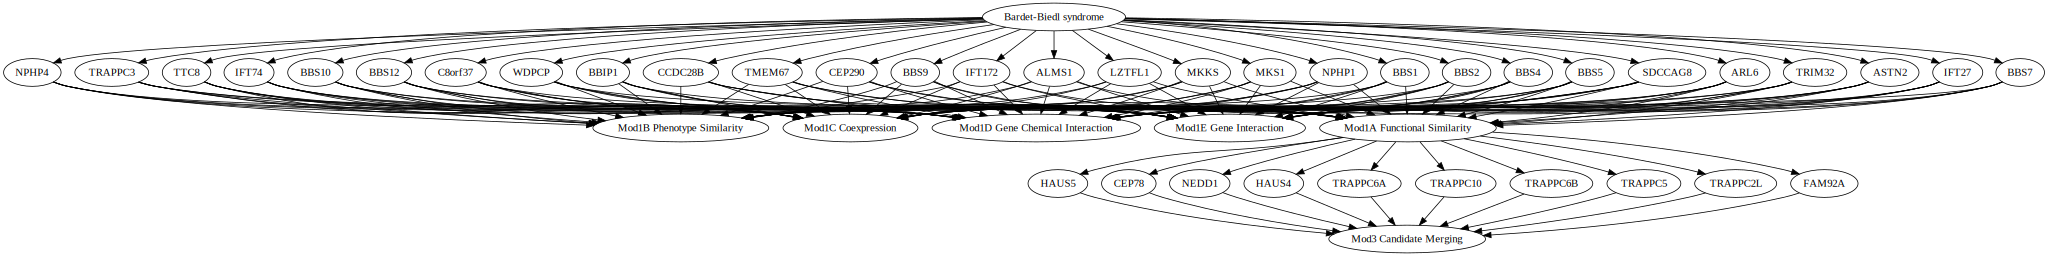

In [36]:
# graph mod1A genes 2 Mod3
for index, row in Mod1A_results.iterrows():
    mod1_candidates.append({
        'input_curie': row[0],
        'output_curie': row[1],
        'output_name': row[2],
        'module': 'Mod1A',
        'score': row[3],
    }) 
path_graph.load_nodes(list(zip(Mod1A_results['sim_hit_curie'][:10], Mod1A_results['sim_hit_name'][:10])))
path_graph.module_inputs(input_gene_set=Mod1A_results['sim_hit_curie'].tolist()[:10], module_id='Mod3')
path_graph.module_outputs(output_gene_set=Mod1A_results['sim_hit_curie'].tolist()[:10], module_id='Mod1A')
path_graph.path_graph

# Mod1B Phenotype Similarity
## Find similar genes based on OwlSim calculated Phenotype Similarity

In [16]:
from Modules.Mod1B1_phenotype_similarity import PhenotypeSimilarity

# Module specification
pheno_sim = PhenotypeSimilarity()

Mod1B Phenotype Similarity metadata:
{'input_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'output_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'predicate': ['blm:has phenotype'],
 'source': 'Monarch Biolink'}


In [17]:
mod1b_input_object = {
    'input': input_curie_set,
     'parameters': {
        'taxon': 'human',
        'threshold': .50,
    },
}
pheno_sim.load_input_object(mod1b_input_object)
pheno_sim.load_gene_set()
pheno_sim.load_associations()

In [18]:
# compute phenotype similarity
Mod1B_results = pd.DataFrame(pheno_sim.compute_similarity())

In [30]:
def sum_scores(score_list):
    return sum(map(float,score_list))

Mod1B_results = Mod1B_results[~Mod1B_results['sim_hit_name'].isin(disease_associated_genes['hit_label'])]
groupedMod1B_results = Mod1B_results.groupby(['sim_hit_curie', 'sim_hit_name'])['sim_score'].apply(sum_scores).reset_index()
Mod1B_merged = pd.merge(groupedMod1B_results, 
         Mod1B_results.groupby(['sim_hit_curie'])['input_curie'].apply(', '.join).reset_index(),
        on='sim_hit_curie').sort_values(['sim_score'], ascending=False).reset_index()
Mod1B_merged.head(10)

,index,sim_hit_curie,sim_hit_name,sim_score,input_curie
0,41,HGNC:21575,AHI1,4.816961,"HGNC:13210, HGNC:20087, HGNC:26291, HGNC:27232..."
1,58,HGNC:29077,IFT140,4.106294,"HGNC:13210, HGNC:20087, HGNC:26291, HGNC:27232..."
2,33,HGNC:19977,RDH12,3.458984,"HGNC:13210, HGNC:20087, HGNC:27232, HGNC:30391..."
3,23,HGNC:15946,RP1L1,3.363253,"HGNC:13210, HGNC:20087, HGNC:26291, HGNC:27232..."
4,56,HGNC:26527,HGSNAT,3.348189,"HGNC:13210, HGNC:20087, HGNC:27232, HGNC:30391..."
5,4,HGNC:10274,RP2,3.074137,"HGNC:13210, HGNC:20087, HGNC:27232, HGNC:966, ..."
6,3,HGNC:10263,RP1,3.067083,"HGNC:13210, HGNC:20087, HGNC:27232, HGNC:966, ..."
7,53,HGNC:26147,AGBL5,3.066310,"HGNC:13210, HGNC:20087, HGNC:27232, HGNC:966, ..."
8,65,HGNC:32528,PRCD,3.060642,"HGNC:13210, HGNC:20087, HGNC:27232, HGNC:966, ..."
9,25,HGNC:16505,CYGB,3.060642,"HGNC:13210, HGNC:20087, HGNC:27232, HGNC:966, ..."


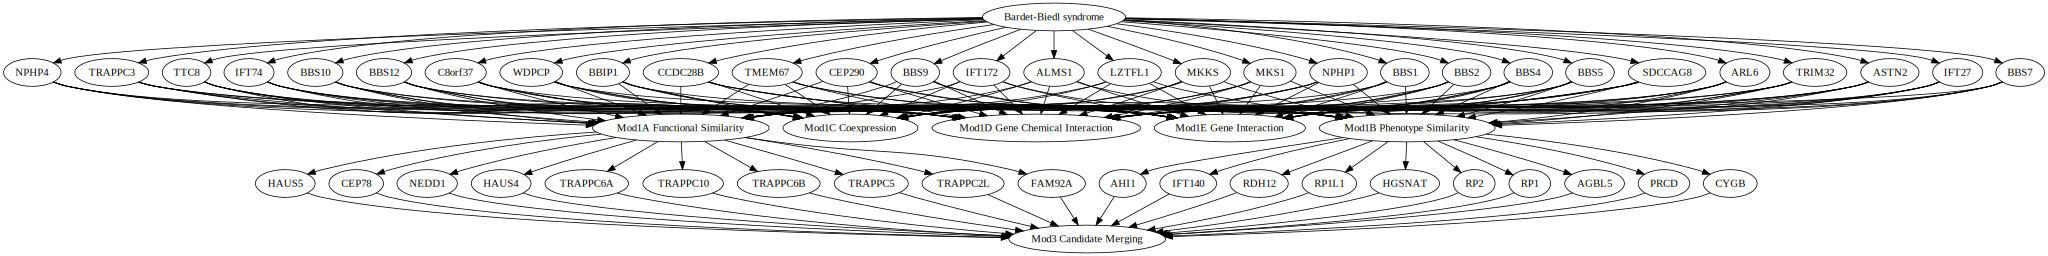

In [37]:
# graph mod1B genes 2 Mod3
for index, row in Mod1B_results.iterrows():
    mod1_candidates.append({
        'input_curie': row[-1],
        'output_curie': row[0],
        'output_name': row[1],
        'module': 'Mod1B',
        'score': row[2]
    }) 
path_graph.load_nodes(list(zip(Mod1B_merged['sim_hit_curie'][:10], Mod1B_merged['sim_hit_name'][:10])))
path_graph.module_outputs(output_gene_set=Mod1B_merged['sim_hit_curie'].tolist()[:10], module_id='Mod1B')
path_graph.module_inputs(input_gene_set=Mod1B_merged['sim_hit_curie'].tolist()[:10], module_id='Mod3')
path_graph.path_graph

# Mod1C Coexpression

In [ ]:
# TODO

# Mod1D Chemical Gene Interactions

In [38]:
# TODO

# Mod1E Gene Interactions

In [39]:
from Modules.Mod1E_interactions import GeneInteractions
gene_inter = GeneInteractions()

Mod1E Interaction Network metadata:
{'input_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'output_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'predicate': ['blm:interacts with'],
 'source': 'Monarch Biolink'}


In [40]:
mod1e_input_object = {
    'input': input_curie_set,
     'parameters': {
        'taxon': 'human',
        'threshold': None,
    },
}
gene_inter.load_input_object(input_object=mod1e_input_object)
gene_inter.load_gene_set()

In [41]:
gene_inter.get_interactions()

In [48]:
Mod1E_results = pd.DataFrame(gene_inter.interactions)
Mod1E_results = Mod1E_results[~Mod1E_results['hit_label'].isin(disease_associated_genes['hit_label'])]
grouped_Mod1E_results = Mod1E_results.groupby(['hit_id','hit_label'])['input_id'].apply(', '.join).reset_index()
trimmed_Mod1E_results = list()
for index, row in grouped_Mod1E_results.iterrows():
    if len(row[-1].split(',')) > 8:
        trimmed_Mod1E_results.append(row)
Mod1E_results = pd.DataFrame(trimmed_Mod1E_results, columns=['hit_id', 'hit_label', 'input_id']).reset_index()
Mod1E_results

,index,hit_id,hit_label,input_id
0,34,HGNC:11119,SMO,"HGNC:13210, HGNC:18758, HGNC:20087, HGNC:28093..."
1,40,HGNC:11332,SSTR3,"HGNC:13210, HGNC:18758, HGNC:20087, HGNC:28093..."
2,52,HGNC:11655,TCP1,"HGNC:18758, HGNC:20087, HGNC:26291, HGNC:26648..."
3,148,HGNC:1615,CCT2,"HGNC:18758, HGNC:20087, HGNC:26291, HGNC:26648..."
4,150,HGNC:1616,CCT3,"HGNC:18758, HGNC:20087, HGNC:26291, HGNC:26648..."
5,151,HGNC:1617,CCT4,"HGNC:17021, HGNC:18758, HGNC:20087, HGNC:26291..."
6,152,HGNC:1618,CCT5,"HGNC:18758, HGNC:20087, HGNC:26291, HGNC:26648..."
7,157,HGNC:1623,CCT8,"HGNC:18758, HGNC:20087, HGNC:26291, HGNC:26648..."
8,164,HGNC:16508,RAB3IP,"HGNC:10671, HGNC:13210, HGNC:18758, HGNC:19104..."
9,501,HGNC:29168,RPGRIP1L,"HGNC:10671, HGNC:19104, HGNC:21424, HGNC:28396..."


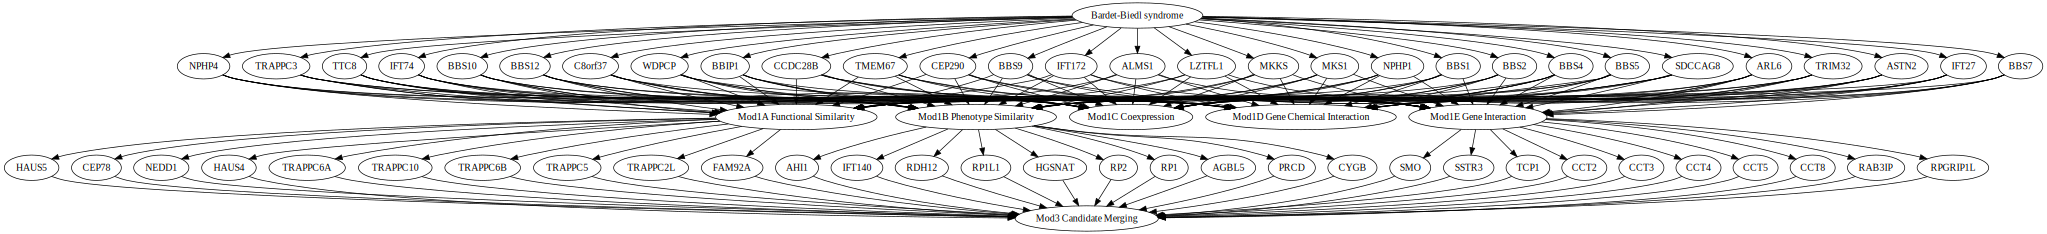

In [49]:
# graph mod1E genes 2 Mod3
for index, row in Mod1E_results.iterrows():
    mod1_candidates.append({
        'input_curie': row[-1],
        'output_curie': row[0],
        'output_name': row[1],
        'module': 'Mod1E',
        'score': None
    })

path_graph.load_nodes(list(zip(Mod1E_results['hit_id'], Mod1E_results['hit_label']))[:10])
path_graph.module_outputs(output_gene_set=Mod1E_results['hit_id'].tolist()[:10], module_id='Mod1E')
path_graph.module_inputs(input_gene_set=Mod1E_results['hit_id'].tolist()[:10], module_id='Mod3')
path_graph.path_graph

## Mod1A with mouse orthologs

In [ ]:
input_genes = disease_associated_genes['hit_id'].tolist()
mouse_orthologs = []
for igene in input_genes:
    ortholog = blw.gene2orthologs(gene_curie=igene)
    mouse_orthologs = mouse_orthologs + [x['object']['id'] for x in ortholog['associations'] if x['object']['taxon']['id'] == 'NCBITaxon:10090']  

In [ ]:
# Module specification
mod1b_mouse_config = {
    'input': mouse_orthologs,
    'input_type': {
        'complexity': 'set',
        'id_type': 'HGNC',
        'data_type': 'gene',
    },
    'output_type': {
        'complexity': 'set',
        'id_type': 'HGNC',
        'data_type': 'gene',
    },
    'parameters': {
        'taxon': 'human',
        'threshold': 100,
    },
    'source': 'Monarch Biolink',
    'predicate': ['blm:has phenotype']
}

pheno_sim_mouse = PhenotypeSimilarity()
pheno_sim_mouse.load_gene_set(mod1b_mouse_config['input'])
pheno_sim_mouse.load_associations()
Mod1B_results_mouse = pheno_sim_mouse.similarity_search()

In [ ]:
Mod1B_results

In [ ]:
scored_Mod1B_mouse = Mod1B_results_mouse[Mod1B_results_mouse['summed_score'] > 100]

In [ ]:
human_hits = []
for mgene in scored_Mod1B_mouse['id'].tolist():
    mousegene_orthologs = blw.gene2orthologs(mgene)
    human_hits = human_hits + [x['object']['id'] for x in mousegene_orthologs['associations'] if x['object']['taxon']['id'] == 'NCBITaxon:9606']


In [ ]:
human_hits_df = []
for hit in human_hits:
    human_hits_df.append(blw.get_obj(hit))
human_pheno_hits_df = pd.DataFrame(human_hits_df)    

In [ ]:
mouse_human_hits = human_pheno_hits_df[['id', 'label']]
mouse_human_hits

In [ ]:
for index, row in mouse_human_hits.iterrows():
    mod1_candidates.append({
        'input_curie': None,
        'output_curie': row[0],
        'output_name': row[1],
        'module': 'Mod1B(mouse)',
        'score': None,
    })

In [ ]:
mod1_candidates

In [ ]:
candidates_df = pd.DataFrame(mod1_candidates)

In [ ]:
candidates_df

In [ ]:
candidates_df.groupby(['output_name'])['module'].apply(', '.join).reset_index()